<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

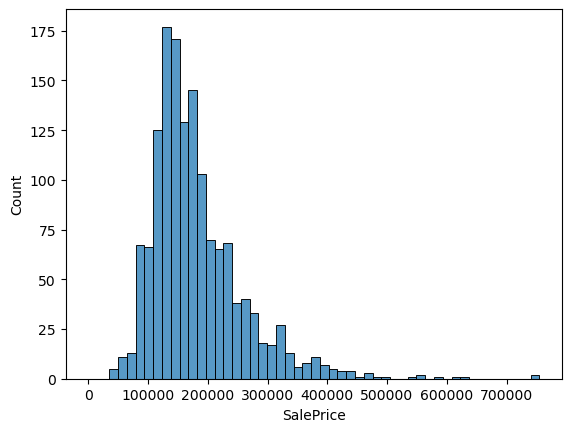

In [1]:
#Regression - House sale price prediction
import os
import pandas as pd
from sklearn import tree
from sklearn import metrics
from sklearn import model_selection
import numpy as np
import io, pydotplus
import math
import seaborn as sns

#returns current working directory
os.getcwd()
#changes working directory
os.chdir("C:/Users/prani/Downloads")

house_train = pd.read_csv(r"C:\Users\prani\Downloads\house-prices-advanced-regression-techniques\train_house.csv")
house_train.shape
house_train.info()

house_test = pd.read_csv(r"C:\Users\prani\Downloads\house-prices-advanced-regression-techniques\test_house.csv")
house_test.shape
house_test.info()

#Concatenate train and test data and we will seperate before applying the model
house_data = pd.concat([house_train, house_test],ignore_index=True)
house_data.drop(["Id","SalePrice"], axis=1, inplace=True)
house_data.shape
house_data.info()

#convert numerical columns to categorical type              
house_data['MSSubClass'] = house_data['MSSubClass'].astype('category')

#convert categorical columns to numeric type
ordinal_features1 = ["ExterQual", "ExterCond", "BsmtQual", "BsmtCond", "GarageQual", "GarageCond", "PoolQC", "FireplaceQu", "KitchenQual", "HeatingQC"]
#ordinal_features1 = [col for col in house_train if 'TA' in list(house_train[col])]
quality_dict = {None: 0, "Po": 1, "Fa": 2, "TA": 3, "Gd": 4, "Ex": 5}
for feature in ordinal_features1:
    null_idx = house_data[feature].isnull()
    house_data.loc[null_idx, feature] = None 
    house_data[feature] = house_data[feature].map(quality_dict)
print(house_data['ExterQual'])
#==============================================================================
# house_data.head(100)
# house_data['BsmtCond']
#==============================================================================

#handle missing data columns
#See for how many rows the data is missing!
total_missing = house_data.isnull().sum()

#for just dry run, go ahead and delete where the data is missing.
#This is just for a dry run to understand the next steps.
#in reality, we have impute these values
to_delete = total_missing[total_missing>0]
house_data.drop(list(to_delete.index), axis=1, inplace=True)
house_data.shape

#Numerical columns.. include=['number']
numeric_cols = house_data.select_dtypes(include=['number']).columns
#Categorical columns .. exclude = ['number'])
cat_cols = house_data.select_dtypes(exclude = ['number']).columns

#Automated to get all category columns and use one hot encoding instead of writing each and every column
house_data1 = pd.get_dummies(house_data, columns=cat_cols)
house_data1.shape

#Plot my sale price
x = house_train['SalePrice']
sns.histplot(x, kde=False)

#splitting train data as conctenated in the begining
house_train1 = house_data1[:house_train.shape[0]]
#splitting test data as conctenated in the begining
house_test1 = house_data1[house_train.shape[0]:]

#Smooting the values. As the sale price is big
house_train['log_sale_price'] = np.log(house_train['SalePrice'])

#See how the data looks like with log values.
x=house_train['log_sale_price']
sns.histplot(x,kde=False)

X_train = house_train1
y_train = house_train['SalePrice']

dt_estimator = tree.DecisionTreeRegressor(random_state=2017)


#evaluate using r^2
#model_selection.cross_val_score(dt_estimator, X_train, y_train, cv=10, scoring="r2").mean()

#evaluate using rmse - 1
#==============================================================================
# res = model_selection.cross_val_score(dt_estimator, X_train, y_train, cv=10,scoring="neg_mean_squared_error").mean()
# math.sqrt(-res)
# 
#==============================================================================

#evaluate using rmse - 2
#RMSE: Root Mean Squared Error
def rmse(y_original,  y_pred):
    return math.sqrt(metrics.mean_squared_error(y_original, y_pred))
      
res = model_selection.cross_val_score(dt_estimator, X_train, y_train, cv=10, scoring=metrics.make_scorer(rmse)).mean()

dt_estimator.fit(X_train, y_train)
#dt_estimator.feature_importances_

#==============================================================================
# dot_data = io.StringIO() 
# tree.export_graphviz(dt_estimator, out_file = dot_data, feature_names = X_train.columns)
# graph = pydot.graph_from_dot_data(dot_data.getvalue())
# graph.write_pdf("reg-tree1.pdf")
#==============================================================================

X_test = house_test1
log_sales_price = dt_estimator.predict(X_test)
#convert log values back to orignal values by using exponential loss
#house_test['SalePrice'] = np.exp(log_sales_price)
house_test['SalePrice'] = log_sales_price
house_test.to_csv("submission_House.csv", columns=['Id','SalePrice'], index=False)